1. JDK 설치
    - https://www.oracle.com/kr/java/technologies/downloads/#java8-windows
    - 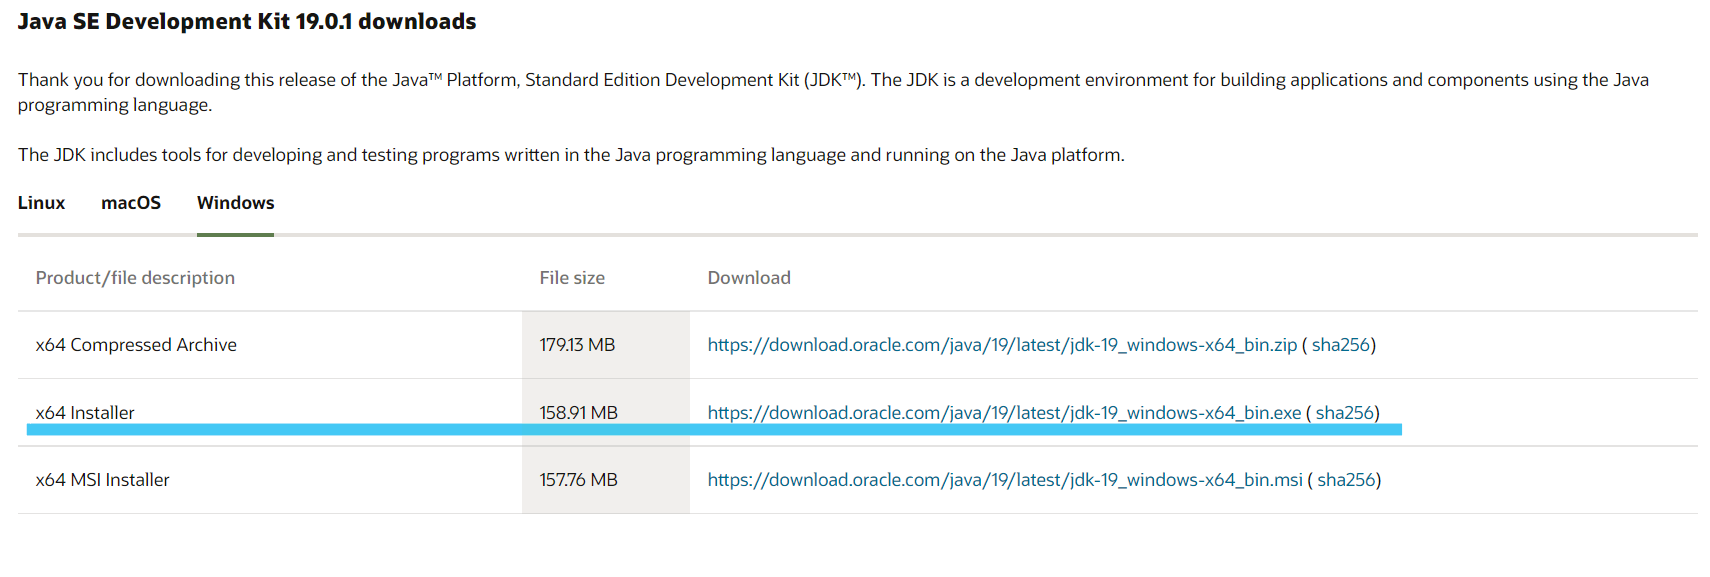
    - 설치 완료 후 시스템 환경설정에 JAVA_HOME 변수에 server 경로 추가
    - 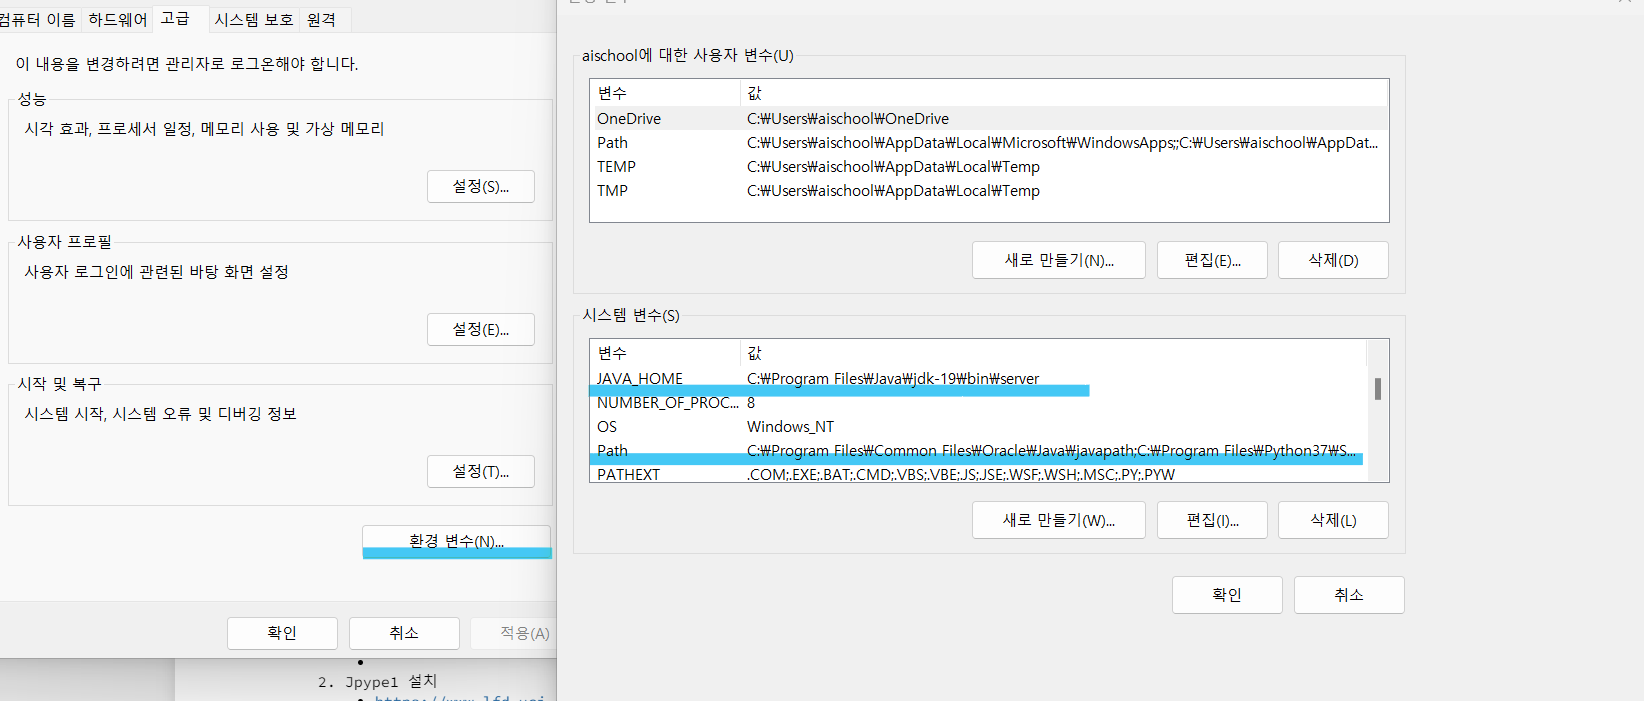
    - path에 bin 경로 추가
    - 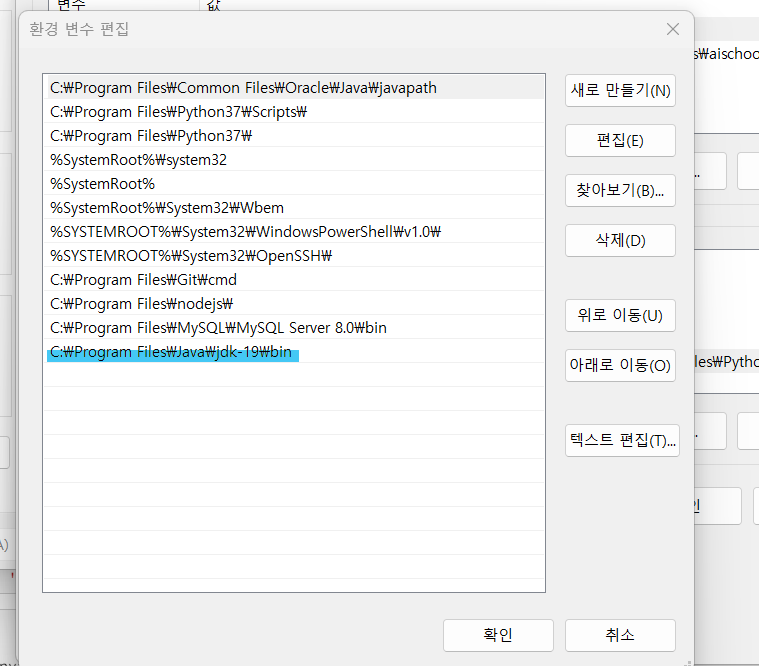
    
2. Jpype1 설치
    - https://www.lfd.uci.edu/~gohlke/pythonlibs/#jpype
    - JPype1‑1.3.0‑cp37‑cp37m‑win_amd64.whl 설치
    - 작업폴더에 다운로드 파일 옮겨넣기
    - 터미널: pip install JPype1-1.3.0-cp37-cp37m-win_amd64.whl
3. konlpy 설치
    - pip install konlpy

In [1]:
import os

print("JAVA_HOME" in os.environ)

False


In [2]:
os.environ['JAVA_HOME'] = 'C:/Program Files/Java/jdk-19/bin/server'

In [3]:
import os

print("JAVA_HOME" in os.environ)

True


In [36]:
import warnings
warnings.filterwarnings(action="ignore")

import matplotlib as mol
mol.rcParams['axes.unicode_minus'] = False

# 영화 리뷰 예제

## 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

### 1) 데이터 로드하기

##### - 라이브러리 임포트

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

okt = Okt()

##### - url로 파일 가져오기

In [6]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x25a7d3ef3c8>)

In [9]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [14]:
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [11]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [15]:
print('훈련용 리뷰 개수:', len(train_data))

훈련용 리뷰 개수: 150000


### 2) 데이터 정의하기

In [16]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [17]:
train_data['label'].unique()

array([0, 1], dtype=int64)

In [18]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

# keep='first' (default)
# 'first', 'last', False

In [21]:
print('총 샘플의 수:', len(train_data))

총 샘플의 수: 146183


<AxesSubplot:>

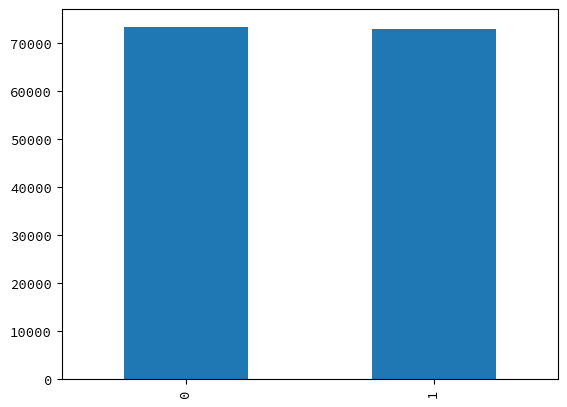

In [23]:
plt.rcParams['font.family'] = 'Source Code Pro'
train_data['label'].value_counts().plot(kind = 'bar')

In [25]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,73342
1,1,72841


In [27]:
train_data.isnull().values.any()

True

In [26]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [28]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [29]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data.isnull().values.any() # Null 값이 존재하는지 확인

False

In [30]:
len(train_data)

146182

##### - 데이터 전처리

In [31]:
#알파벳과 공백을 제외하고 모두 제거한 예시
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [37]:
# 한글과 공백을 제외하고 모두 제거 (ㄱ-ㅎ / ㅏ-ㅣ / 가-힣 / 공백)
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [38]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

id            0
document    789
label         0
dtype: int64

In [39]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [40]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


##### - 테스트 데이터도 똑같이 전처리 작업 진행

In [41]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


### 3) 토큰화

In [42]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 불용어: 분석에 큰 의미가 없는 단어

In [43]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)

# Okt() => 토큰단위로 분해시키는 작업을 진행 (한글 => 형태소 단위로 분해)
# 형태소: 의미를 가지는 가장 작은 단위
# morphs(): 형태소로 변환시켜주는 함수
# stem=True: 어간, 어미를 변경시켜줌

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

#####  cf) 참고 - 명사만 추출

- morphs(text) : 텍스트에서 형태소를 반환한다
- nouns(text) : 텍스트에서 명사를 반환한다
- phrases(text) : 텍스트에서 어절을 뽑아낸다
- pos(text) : 텍스트에서 품사 정보를 부착하여 반환한다

In [45]:
okt.nouns('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔')

['것', '영화', '차라리', '뮤직비디오', '게', '뻔']

---

In [44]:
X_train = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 145393/145393 [06:03<00:00, 399.83it/s]


In [46]:
X_train[:3]

[['아', '더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]

In [47]:
X_test = []

for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48852/48852 [02:14<00:00, 362.17it/s]


In [48]:
X_test[:3]

[['굳다', 'ㅋ'],
 ['뭐', '야', '평점', '나쁘다', '않다', '점', '짜다', '리', '더', '더욱', '아니다'],
 ['지루하다', '않다', '완전', '막장', '임', '돈', '주다', '보기', '에는']]

### 4) 정수 인코딩

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [50]:
tokenizer.word_index

{'영화': 1,
 '보다': 2,
 '을': 3,
 '없다': 4,
 '이다': 5,
 '있다': 6,
 '좋다': 7,
 '너무': 8,
 '다': 9,
 '정말': 10,
 '되다': 11,
 '재밌다': 12,
 '적': 13,
 '만': 14,
 '같다': 15,
 '진짜': 16,
 '로': 17,
 '아니다': 18,
 '않다': 19,
 '점': 20,
 '에서': 21,
 '만들다': 22,
 '나오다': 23,
 '연기': 24,
 '것': 25,
 '평점': 26,
 '내': 27,
 '최고': 28,
 '그': 29,
 '나': 30,
 '안': 31,
 '인': 32,
 '스토리': 33,
 '생각': 34,
 '못': 35,
 '왜': 36,
 '드라마': 37,
 '게': 38,
 '감동': 39,
 '사람': 40,
 '보고': 41,
 '이렇다': 42,
 '말': 43,
 '고': 44,
 '아깝다': 45,
 '더': 46,
 '배우': 47,
 '때': 48,
 'ㅋㅋ': 49,
 '아': 50,
 '감독': 51,
 '거': 52,
 '그냥': 53,
 '재미있다': 54,
 '요': 55,
 '재미': 56,
 '시간': 57,
 '내용': 58,
 '뭐': 59,
 '까지': 60,
 '중': 61,
 '주다': 62,
 '자다': 63,
 '하고': 64,
 '지루하다': 65,
 '재미없다': 66,
 '쓰레기': 67,
 '수': 68,
 '네': 69,
 '모르다': 70,
 '가다': 71,
 '들다': 72,
 '그렇다': 73,
 '싶다': 74,
 '지': 75,
 '작품': 76,
 '사랑': 77,
 '알다': 78,
 '하나': 79,
 '다시': 80,
 '마지막': 81,
 '볼': 82,
 '이건': 83,
 '정도': 84,
 '저': 85,
 '완전': 86,
 '오다': 87,
 'ㅋ': 88,
 'ㅠㅠ': 89,
 '많다': 90,
 '처음': 91,
 'ㅋㅋㅋ': 92,
 '장면': 9

In [51]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [52]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


In [53]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [54]:
X_train[:3]

[[50, 454, 16, 260, 659],
 [933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19],
 [386, 2444, 2315, 5671, 2, 222, 9]]

In [64]:
X_train[27:29]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 8631, 3072,  577],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 2194,    6,
         110,  362, 2526,  458,  372, 2525,  545,   20]])

In [55]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

### 5) 빈 샘플 (empty samples) 제거

In [56]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [65]:
drop_train

[28,
 414,
 1149,
 1347,
 1572,
 1711,
 2321,
 2345,
 2432,
 3440,
 4289,
 4612,
 4809,
 5021,
 5722,
 7141,
 7790,
 9660,
 10596,
 10973,
 11669,
 12722,
 12766,
 12896,
 13788,
 15427,
 16782,
 18597,
 18626,
 19286,
 21297,
 24351,
 24583,
 24871,
 25031,
 25860,
 26313,
 27110,
 27497,
 28474,
 28600,
 28938,
 29596,
 29618,
 30187,
 30623,
 32218,
 32462,
 32874,
 32885,
 33701,
 34017,
 34216,
 34919,
 36295,
 37099,
 37481,
 39648,
 40010,
 40364,
 40665,
 43207,
 43312,
 43410,
 43838,
 43922,
 43984,
 44094,
 44629,
 45388,
 46359,
 46788,
 46909,
 47456,
 47865,
 48205,
 48827,
 51094,
 52043,
 52778,
 52980,
 53565,
 54640,
 54875,
 55519,
 56274,
 56971,
 57036,
 57277,
 57391,
 60421,
 60439,
 60718,
 61783,
 61949,
 62106,
 62592,
 63085,
 63487,
 63632,
 64232,
 64332,
 65184,
 65481,
 66049,
 66665,
 67697,
 67928,
 68049,
 69478,
 70138,
 70510,
 71315,
 72129,
 73255,
 74008,
 74186,
 75521,
 75921,
 77418,
 77739,
 78027,
 78051,
 78416,
 78887,
 79170,
 79754,
 8055

In [57]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145162
145162


### 6) 패딩

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


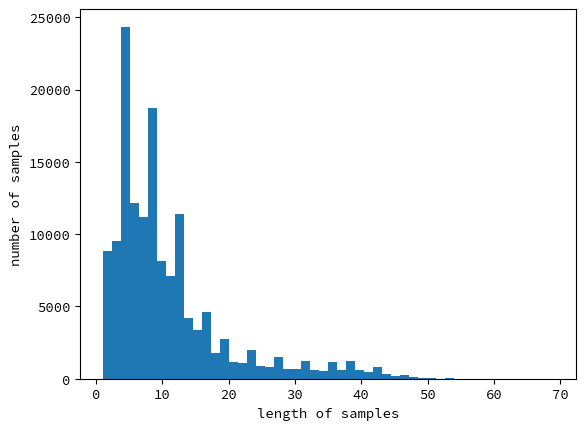

In [58]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [68]:
def below_threshold_len(max_len, nested_list):
    count = 0

    for sentence in nested_list:
        if (len(sentence) <= max_len):
            count = count + 1

    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [69]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 100.0


In [70]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [71]:
X_train[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   50,  454,   16,  260,  659],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  933,  457,   41,
         602,    1,  214, 1449,   24,  961,  675,   19],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  386, 2444, 2315, 5671,    2,  222,    9]])

## 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

---
### EarlyStopping() : 검증셋에서 손실이 더이상 감소하지 않으면 중단.

- monitor : 
    - EarlyStopping 적용할지 여부를 결정할 때 기준이 되는 값 지정 
    - loss, val_loss, accuracy, val_accuracy등을 지정 
    - 보통 Model.compile 메소드에 지정한 metrics과 관련된 것으로 지정한다. 
- min_delta : 
    - min_delta에서 지정한 값만큼 monitor에서 지정한 값이 변했어야 
    - mode에서 지정한 방향으로 값이 변한 것으로 간주하여 학습 중단 
- patience : 
    - monitor에 지정된 값이 patience에서 지정한 횟수만큼 epoch를 
    - 진행했는데도 개선되지 않았다면 학습을 중단
- mode : 
    - monitor가 accuracy 또는 val_accuracy로 지정된 경우에는 max로 이전 값보다 커지는 경우에만 모델이 저장됩니다. 
    - monitor가 loss 또는 val_loss로 지정된 경우에는 min으로 이전 값보다 작아지는 경우에만 모델이 저장됩니다. 
    - auto의 경우에는 monitor에 지정된 것을 보고 알아서 판단하여 모델 저장.
- baseline : monitor에 지정된 값이 baseline에 지정된 값보다 개선되지 않으면  학습 중단


### ModelCheckpoint() : 검증셋에서 손실이 더 작아질때만 저장

- filepath ='best_model.h5' : 파일명 지정
- monitor='val_acc': 
    - 콜백함수에서 모델을 저장할때 기준이 되는 값을 지정. 
    - loss, val_loss, accuracy, val_accuracy등을 지정할 수 있다. 
- mode : 
    - monitor가 accuracy 또는 val_accuracy로 지정된 경우에는 max로 이전 값보다 커지는 경우에만 모델이 저장됩니다. 
    - monitor가 loss 또는 val_loss로 지정된 경우에는 min으로 이전 값보다 작아지는 경우에만 모델이 저장됩니다. 
    - auto의 경우에는 monitor에 지정된 것을 보고 알아서 판단하여 모델 저장.  
- save_weights_only : Ture이면 모델 가중치만 저장되며 False이면 모델 전체 저장 
- save_best_only   Ture : 이전보다 성능이 좋은 경우에만 모델이 저장
- save_freq : 
    - 'epoch' 또는 정수를 사용. 디폴트 값은 'epoch'
    - 문자열 'epoch'를 값으로 사용하면 각 epoch 끝날때 마다 모델 저장
    - 정수를 값으로 사용하면 지정한 정수만큼의 배치를 사용한 후, 모델 저장
---

In [72]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1814/1815 [============================>.] - ETA: 0s - loss: 0.3904 - acc: 0.8217WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000025A2CFB10D8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

In [73]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1527/1527 [==============================] - 11s 7ms/step - loss: 0.3390 - acc: 0.8546

 테스트 정확도: 0.8546


## 3. 리뷰 예측해보기

In [74]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [76]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 19ms/step
92.37% 확률로 긍정 리뷰입니다.



In [77]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 27ms/step
98.75% 확률로 부정 리뷰입니다.



In [78]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 [==============================] - 0s 22ms/step
99.90% 확률로 부정 리뷰입니다.



In [79]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 [==============================] - 0s 22ms/step
98.61% 확률로 부정 리뷰입니다.



In [80]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 28ms/step
79.34% 확률로 긍정 리뷰입니다.



In [81]:
sentiment_predict('와 너무 좋다. 시간을 이렇게나 많이 썼네?')

1/1 [==============================] - 0s 33ms/step
61.43% 확률로 긍정 리뷰입니다.



In [82]:
sentiment_predict('초반부에 너무 무서워서 뛰쳐나가고 싶었거든요. 그때 안나간거 후회했어요')

1/1 [==============================] - 0s 19ms/step
97.20% 확률로 부정 리뷰입니다.



In [83]:
sentiment_predict(' 마지막 ㅈㄴ강렬하네...내가 왠만하면 공포영화도 잘보고 깜놀타이밍도 잘알고있다고 생각했는데 이건 방심할 틈을안주네 ㅋㅋㅋㅋ 오랜만에 공포영화다운 영화본거같음')

1/1 [==============================] - 0s 17ms/step
99.12% 확률로 긍정 리뷰입니다.



In [84]:
sentiment_predict('진짜 26년 살면서 이 영화가 제일 무서웠다')

1/1 [==============================] - 0s 20ms/step
94.31% 확률로 긍정 리뷰입니다.



In [85]:
sentiment_predict('마음 속에 간직한 트라우마나 상처가 만들어내는 공포가 무섭게 다가옵니다.')

1/1 [==============================] - 0s 26ms/step
99.40% 확률로 긍정 리뷰입니다.

